# THE BEST CLASSIFIER PROJECT

In this project, i at looked applying different classification algorithms such as; K Nearest Neighbor(KNN), Decision Tree, Support Vector Machine (SVM), and Logistic Regression and find the best one for accurately classifying loan defaulting.

### Let's Download Some Required Libraries 

In [168]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### Lets download the dataset 

In [169]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2018-09-22 04:31:10--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[=====================>]  22.56K  --.-KB/s   in 0.02s  

2018-09-22 04:31:10 (1.05 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [170]:
#Load data with pandas
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [171]:
df.shape

(346, 10)

In [172]:
df.dtypes

Unnamed: 0         int64
Unnamed: 0.1       int64
loan_status       object
Principal          int64
terms              int64
effective_date    object
due_date          object
age                int64
education         object
Gender            object
dtype: object

### Convert to date time object 

In [173]:
df['due_date']=pd.to_datetime(df['due_date'])
df['effective_date']=pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


In [174]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

### Let’s look at the number of each class that is in our data set 

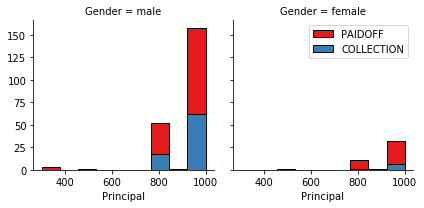

In [175]:
import seaborn as sns

bins=np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

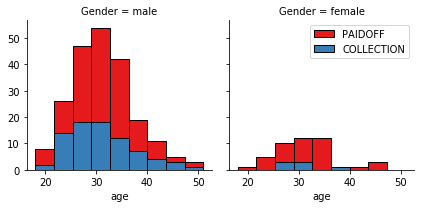

In [176]:
bins=np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing
What day of the week does people get loan

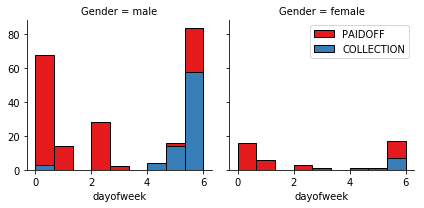

In [177]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins=np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [178]:
df['weekend']= df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

We have a couple of categorical variables in the dataframe. Let's convert those to numeric

(1) Lets look at gender:

In [179]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

Lets convert gender making male to 0 and female to 1:

In [180]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


(2) Let's look education

In [181]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

## One Hot Encoding  

#### Feature (x-variables) before One Hot Encoding

In [182]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Let's use one hot encoding technique to convert categorical varable (education) to binary variables

In [183]:
Feature=df[['Principal','terms','age','Gender','weekend']]
Feature=pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
#Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,Master or Above,college
0,1000,30,45,0,0,0,1,0,0
1,1000,30,33,1,0,1,0,0,0
2,1000,15,27,0,0,0,0,0,1
3,1000,30,28,1,1,0,0,0,1
4,1000,30,29,0,1,0,0,0,1


### Let's select out feature for modeling

Lets define feature sets, X:

In [184]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,Master or Above,college
0,1000,30,45,0,0,0,1,0,0
1,1000,30,33,1,0,1,0,0,0
2,1000,15,27,0,0,0,0,0,1
3,1000,30,28,1,1,0,0,0,1
4,1000,30,29,0,1,0,0,0,1


Lets defind target sets, y:

In [185]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Data Normalization
Now that we have defined out feature and target data, lets normalize the feature data

In [186]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.07624929, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.07624929, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669, -0.07624929,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669, -0.07624929,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669, -0.07624929,  1.14984679]])

# <center>Classification Techniques</center>
Let's look at the following classification techniques
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression


# K-Nearest Neighbor(KNN)

In [187]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=0)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 9) (276,)
Test set: (70, 9) (70,)


In [188]:
k = 7
#Train Model and Predict  
knn = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
knn

yhat = knn.predict(X_test)
yhat[0:5]

array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

### Now let's find the best k value

In [189]:
from sklearn import metrics
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    knn = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=knn.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.7571428571428571 with k= 7


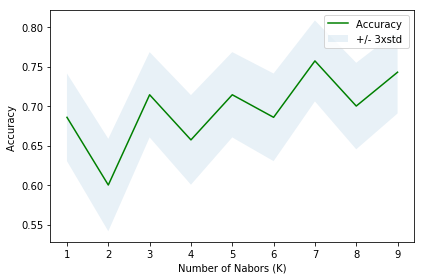

In [190]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [191]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train, knn.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.8043478260869565
Test set Accuracy:  0.7428571428571429


### Confusion Matrix

In [192]:
# confusion matrix
from sklearn.metrics import confusion_matrix

knn_confusion_matrix = confusion_matrix(y_true = y_test, y_pred = yhat)
print("The Confusion matrix:\n", knn_confusion_matrix)

The Confusion matrix:
 [[ 4  8]
 [10 48]]


### Lets's now visualize the Confusion Matrix

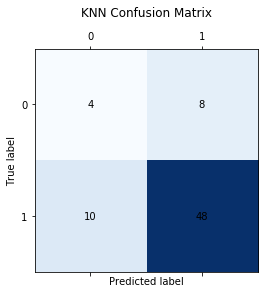

In [193]:
# visualize the confusion matrix
plt.matshow(knn_confusion_matrix, cmap = plt.cm.Blues)
plt.title("KNN Confusion Matrix\n")
plt.ylabel('True label')
plt.xlabel('Predicted label')
for y in range(knn_confusion_matrix.shape[0]):
    for x in range(knn_confusion_matrix.shape[1]):
        plt.text(x, y, '{}'.format(knn_confusion_matrix[y, x]),
                horizontalalignment = 'center',
                verticalalignment = 'center',)
plt.show()

In [194]:
#Generate the classification report
from sklearn.metrics import classification_report
knn_classify_report = classification_report(y_true = y_test, y_pred = yhat)
print(knn_classify_report)

             precision    recall  f1-score   support

 COLLECTION       0.29      0.33      0.31        12
    PAIDOFF       0.86      0.83      0.84        58

avg / total       0.76      0.74      0.75        70



# Decision Tree

In [195]:
from sklearn.model_selection import train_test_split
dis_Tree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
dis_Tree # it shows the default parameters

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [196]:
dis_Tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [197]:
pred_Tree = dis_Tree.predict(X_test)

In [198]:
print (pred_Tree [0:5])
print (y_test [0:5])

['COLLECTION' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF']
['COLLECTION' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF']


In [199]:
from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, pred_Tree))

DecisionTrees's Accuracy:  0.7142857142857143


## Let's visualize the the model

In [200]:
import sys
!conda install --yes --prefix {sys.prefix} pydotplus

Solving environment: / 
  - anaconda::pydotplus-2.0.2-py36_0
  - defaults::pydotplus-2.0.2-py36done

# All requested packages already installed.



In [201]:
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

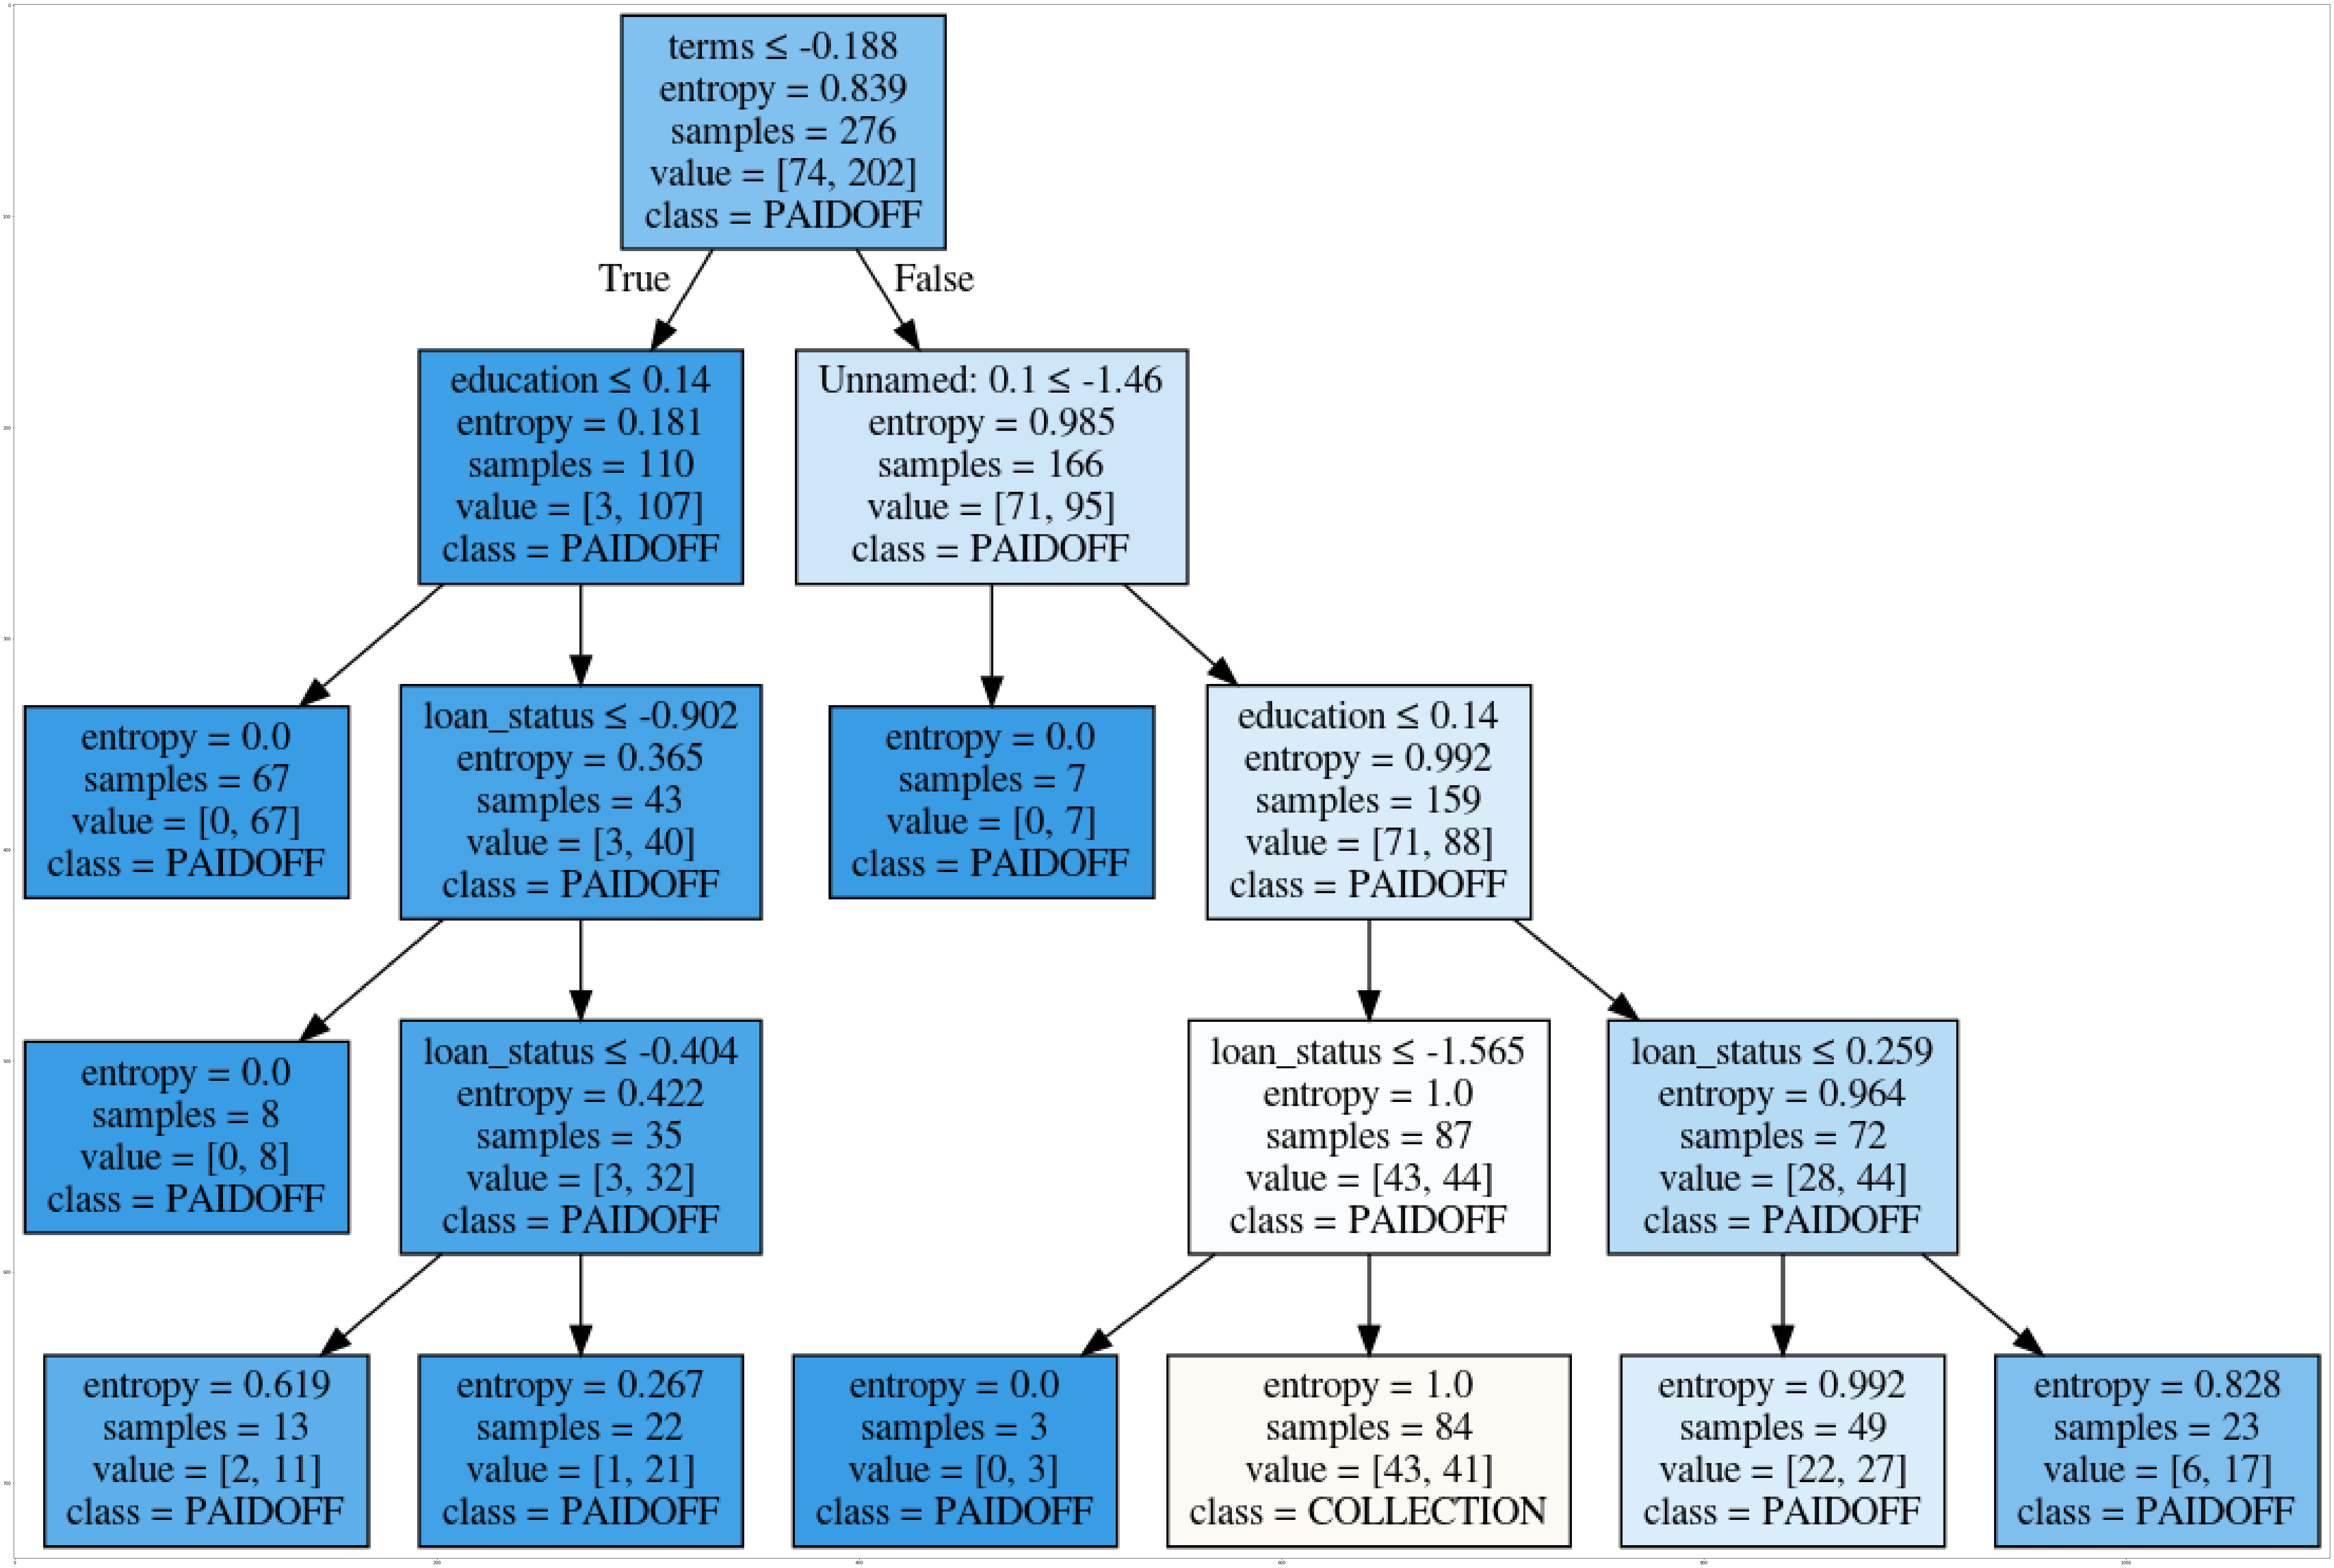

In [202]:
dot_data = StringIO()
filename = "dis_tree.png"
featureNames = df.columns[0:9]
targetNames = df["loan_status"].unique().tolist()
out=tree.export_graphviz(dis_Tree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

# Logistic Regression

In [203]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [204]:
yhat = LR.predict(X_test)
yhat_prob = LR.predict_proba(X_test)


Jaccard Score

In [205]:
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, yhat)

0.8142857142857143

Log Loss

In [206]:
from sklearn.metrics import log_loss
log_loss(y_test, yhat_prob)

0.5390760809782374

# Support Vector Machine

In [209]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [210]:
yhat = clf.predict(X_test)
yhat [0:5]

array(['PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

F1 Score

In [211]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted') 

0.7142857142857143

Jaccard Score

In [212]:
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, yhat)

0.7142857142857143

# Model Evaluation using Test set
Now, let's evaluate the models and determine the best one.
First, let's download and load the test set into df1:

In [213]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2018-09-22 04:36:38--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[=====================>]   3.56K  --.-KB/s   in 0s     

2018-09-22 04:36:38 (67.4 MB/s) - ‘loan_test.csv’ saved [3642/3642]



In [214]:
df1 = pd.read_csv('loan_test.csv')
df1.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [215]:
df1['due_date']=pd.to_datetime(df1['due_date'])
df1['effective_date']=pd.to_datetime(df1['effective_date'])
df1['dayofweek'] = df1['effective_date'].dt.dayofweek

df1['weekend']= df1['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df1['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

In [216]:
Feature1=df1[['Principal','terms','age','Gender','education']]
Feature1.head()

,Principal,terms,age,Gender,education
0,1000,30,50,1,Bechalor
1,300,7,35,0,Master or Above
2,1000,30,43,1,High School or Below
3,1000,30,26,0,college
4,800,15,29,0,Bechalor


In [217]:
Feature1=df1[['Principal','terms','age','Gender','weekend']]
Feature1=pd.concat([Feature1,pd.get_dummies(df1['education'])], axis=1)
#Feature1.drop(['Master or Above'], axis = 1,inplace=True)
Feature1.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,Master or Above,college
0,1000,30,50,1,0,1,0,0,0
1,300,7,35,0,1,0,0,1,0
2,1000,30,43,1,1,0,1,0,0
3,1000,30,26,0,1,0,0,0,1
4,800,15,29,0,1,1,0,0,0


In [218]:
Feature1.dtypes

Principal               int64
terms                   int64
age                     int64
Gender                  int64
weekend                 int64
Bechalor                uint8
High School or Below    uint8
Master or Above         uint8
college                 uint8
dtype: object

In [219]:
#X_test = Feature1['Principal', 'terms', 'age', 'Gender', 'weekend'].astype(int)
#Feature1['Principal']=Feature1.Principal.astype(int)
X_test = Feature1
X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test)
X_test[0:5]


array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -1.30384048,
         2.39791576, -0.79772404, -0.19611614, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404,  5.09901951, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211,  0.76696499,
        -0.41702883,  1.25356634, -0.19611614, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404, -0.19611614,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.76696499,
         2.39791576, -0.79772404, -0.19611614, -0.86135677]])

In [220]:
y_test = df1['loan_status'].values
y_test[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

# Accuracies Per Classification

In [221]:
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_similarity_score,log_loss

Y_knnloadpred = knn.predict(X_test)
Y_dectreeloadpred = dis_Tree.predict(X_test)
Y_svcloadpred = clf.predict(X_test)
Y_logloadpred = LR.predict(X_test)

In [222]:
#jaccard 


kjacc = jaccard_similarity_score(y_test, Y_knnloadpred)
sjacc = jaccard_similarity_score(y_test, Y_svcloadpred)
djacc = jaccard_similarity_score(y_test, Y_dectreeloadpred)
ljacc = jaccard_similarity_score(y_test, Y_logloadpred)

#f-score
kfscore = f1_score(y_test,Y_knnloadpred,average='weighted')
sfscore = f1_score(y_test,Y_svcloadpred,average='weighted')
dfscore = f1_score(y_test,Y_dectreeloadpred,average='weighted')
lfscore = f1_score(y_test,Y_logloadpred,average='weighted')


#logloss
Y_logloadpred_proba = LR.predict_proba(X_test)
lloss =  log_loss(y_test,Y_logloadpred_proba)

/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Classification Algorithm Comparison

In [223]:
df2 = pd.DataFrame(data=[['KNN',kjacc,kfscore,'NA'],
                         ['Decision Tree',djacc,dfscore,'NA'],
                         ['SVM',sjacc,sfscore,'NA'],
                         ['Logistic Regression',ljacc,lfscore,lloss]
                        ],columns=['Algorithm','Jaccard','F1-score','Log-Loss'])
df2

,Algorithm,Jaccard,F1-score,Log-Loss
0,KNN,0.648148,0.620252,NA
1,Decision Tree,0.722222,0.730252,NA
2,SVM,0.740741,0.714431,NA
3,Logistic Regression,0.740741,0.630418,0.577381


The above result gives the comparison of the various classification accuracies.

# THANK YOU!!